

# Amazon Fine Food Reviews — NLP Sentiment Analysis Pipeline

## Overview  
End-to-end **NLP text-classification** pipeline that converts raw Amazon review text into **positive/negative** sentiment predictions. The workflow includes rigorous data hygiene, **negation-aware** preprocessing, multiple feature representations (**BoW, TF-IDF, Word2Vec**), and comparative modeling (**Logistic Regression, Multinomial Naive Bayes, Random Forest**) with cross-validated tuning. **Best model (LogReg + TF-IDF)** attains **~0.91 Accuracy** and **~0.91 Macro-F1** on a held-out test set.

## Objectives
- Define a clear **positive/negative** target from review scores (exclude neutral = 3).
- Apply **negation-aware** text cleaning for high-quality inputs.
- Engineer **BoW**, **TF-IDF (uni/bi-grams)**, **Word2Vec** representations.
- Train & compare **LogReg / MNB / RF** with **GridSearchCV**.
- Report **Accuracy, Precision, Recall, F1**; add word-cloud insights.

## Dataset
- Amazon Fine Food Reviews (`Reviews.csv`)
- Labels: `Score > 3 → 1`, `Score < 3 → 0` (neutral = 3 dropped)
- De-duplication + helpfulness consistency checks

## Methodology
1) **Preprocess (negation-aware):** strip URLs/HTML, de-contract, normalize tokens, keep negations  
2) **Balance & split:** under-sample → **train/test = 80/20**  
3) **Vectorize:** **CountVectorizer**, **TfidfVectorizer(1–2-grams)**, **Word2Vec** sentence means  
4) **Model & tune:** **LogReg (GridSearchCV)**, **MNB**, **RF**  
5) **Evaluate:** Accuracy, Precision, Recall, F1 (+ word clouds)

## Results  
| Model                    | Features | Accuracy | Macro-F1 |
|-------------------------|----------|----------|----------|
| Logistic Regression     | TF-IDF   | ~0.91    | ~0.91    |
| Multinomial Naive Bayes | BoW      | ~0.866   | ~0.86    |
| Random Forest           | TF-IDF   | ~0.877   | ~0.87    |
| Random Forest           | Word2Vec | ~0.593   | ~0.59    |

**Stack:** Python, scikit-learn, NLTK, gensim, BeautifulSoup, imbalanced-learn


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk  #natural language processing toolkit

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

# Change the path according to where you uploaded it
file_path = "/content/drive/MyDrive/Reviews.csv"

df = pd.read_csv(file_path)
print(df.shape)



(568454, 10)


In [6]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
#removing data where score == 3
df = df[df['Score'] != 3]
print(df.shape)
df.head(2)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [8]:
#giving a value of 1 to positive reviews(score > 3) and 0 to negative reviews
df['positive_negative'] = 0
df.loc[df['Score']>3, 'positive_negative'] = 1
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positive_negative
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0


In [9]:
df_grouped = df.groupby('UserId').size().reset_index(name='count')
df_grouped = df_grouped.loc[df_grouped['count']>1]
print(df_grouped.shape)
df_grouped.head()

(75346, 2)


,UserId,count
4,#oc-R115TNMSPFT9I7,2
6,#oc-R11D9D7SHXIJB9,3
7,#oc-R11DNU2NBKQ23Z,2
8,#oc-R11O5J5ZVQE25C,3
10,#oc-R12KPBODL2B5ZD,2


In [10]:
df_grouped['count'].sum()

357746

# **Exploratory Data Analysis**

### Data cleaning: Deduplication

In [11]:
df_sample = df.loc[df['UserId'] == "AR5J8UI46CURR"]
df_sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positive_negative
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,1
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,1
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,1
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,1
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,1


When searched online (www.amazon.com/dp/productId) all the product ids mentioned here represnt the same product with different flavours which are just like the optons avaialbe for a product. Therefore for review we should have only one of them.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_df = df.sort_values('ProductId', ascending = True, axis = 0, inplace = False, kind = 'quicksort', na_position = 'last')
sorted_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positive_negative
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",1
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,1
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,5,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,1
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,5,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,1
...,...,...,...,...,...,...,...,...,...,...,...
191720,191721,B009UOFTUI,AJVB004EB0MVK,D. Christofferson,0,0,1,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w...",0
1477,1478,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,1,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w...",0
328481,328482,B009UUS05I,ARL20DSHGVM1Y,Jamie,0,0,5,1331856000,Perfect,The basket was the perfect sympathy gift when ...,1
5702,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,5,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,1


In [13]:
#Deduplication of entries
final_df = sorted_df.drop_duplicates(subset = {"UserId", "ProfileName", "Time", "Text"}, inplace = False, keep = 'first')
final_df.shape

(364173, 11)

**Observation:-** It was observed that in few rows the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these rows too are removed from calcualtions

In [14]:
final_df=final_df[final_df.HelpfulnessNumerator<=final_df.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final_df.shape)

#How many positive and negative reviews are presnt in our dataset?
final_df['positive_negative'].value_counts()

(364171, 11)


,count
positive_negative,
1,307061
0,57110


Unbalanced dataset. We will deal with it later

# Text Preprocessing

In [16]:
#Printing some random reviews
snt_0 = final_df['Text'].values[0]
print(snt_0)
print('='*50)
snt_100 = final_df['Text'].values[100]
print(snt_100)
print('='*50)
snt_1000 = final_df['Text'].values[1000]
print(snt_1000)
print('='*50)
snt_10000 = final_df['Text'].values[10000]
print(snt_10000)
print('='*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
Pros:<br />Dog will do anything for this treat.<br />Doesn't smell as bad as many other treats.<br />Easy to break into smaller pieces.<br />Nothing artificial, easy digestion.<br /><br />Cons:<br />More costly than other dog treats.<br /><br />Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise

In [17]:
#remove urls
import re

snt_100 = re.sub(r"http\S+", "", snt_100)

print(snt_100)

Pros:<br />Dog will do anything for this treat.<br />Doesn't smell as bad as many other treats.<br />Easy to break into smaller pieces.<br />Nothing artificial, easy digestion.<br /><br />Cons:<br />More costly than other dog treats.<br /><br />Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.


In [18]:
#remove html tags
from bs4 import BeautifulSoup

soup = BeautifulSoup(snt_100, 'lxml')
text = soup.get_text()
print(text)

Pros:Dog will do anything for this treat.Doesn't smell as bad as many other treats.Easy to break into smaller pieces.Nothing artificial, easy digestion.Cons:More costly than other dog treats.Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.


In [19]:
def decontracted(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
#remove numbers and alphanumeric words
snt_1000 = re.sub("\S*\d\S*", "", snt_1000)
print(snt_1000)

I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered  boxes - both were expired! One expired back in  for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez,  years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-3871590176.py:2: SyntaxWarning: invalid escape sequence '\S'
  snt_1000 = re.sub("\S*\d\S*", "", snt_1000)


In [21]:
#remove special characters
snt_1000 = re.sub('[^A-Za-z0-9]+', " ", snt_1000)
print(snt_1000)

I was really looking forward to these pods based on the reviews Starbucks is good but I prefer bolder taste imagine my surprise when I ordered boxes both were expired One expired back in for gosh sakes I admit that Amazon agreed to credit me for cost plus part of shipping but geez years expired I m hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks 


In [22]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
print(len(stopwords))
print(stopwords)

198
{'about', 'at', 'up', 'ours', 'all', 'i', "shouldn't", 'after', 've', "you'll", "you've", 'just', 'your', 'before', "won't", "they're", 'because', "he'll", "needn't", 'than', "don't", 'itself', 'has', 'what', "we've", 'now', 'for', 'have', 'do', 'did', 'there', 'was', 'myself', "isn't", 'wouldn', 'then', 'where', "i'm", 'didn', 'won', 'not', 'ourselves', 'am', 'be', 'y', 'can', 'my', "it'd", 'were', 'further', 'being', "doesn't", 'ma', 'weren', 'haven', "mightn't", 'he', 'here', 'with', "wasn't", "we're", 'needn', "he'd", 'on', 'off', 'ain', "i've", 'very', "you'd", 'herself', 'when', "you're", 'same', 'o', "we'll", 'such', 'each', 'had', 'mightn', 'own', 'they', 'that', "it's", "she'll", 'will', 'once', 'whom', 'from', 'doing', 'more', "they'll", 'and', 'having', 'out', "should've", "wouldn't", 'you', 'any', 'himself', "they'd", 'as', 'why', 't', 'if', 'other', "she'd", "that'll", 'd', 'these', 'couldn', 'below', 'how', 'm', 'to', 'hadn', 'no', "shan't", 'of', 'mustn', 'until', 'i

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
#Removing negative stopwords from stopwords

negative_stopwords = set(word for word in stopwords
                          if "n't" in word or 'no' in word or "n'" in word)

final_stopwords = stopwords - negative_stopwords
print(len(final_stopwords))
print(final_stopwords)

176
{'about', 'at', 'up', 'ours', 'all', 'i', 'after', 've', "you'll", "you've", 'just', 'your', 'before', "they're", 'because', "he'll", 'than', 'itself', 'has', 'what', "we've", 'for', 'have', 'do', 'did', 'there', 'was', 'myself', 'wouldn', 'then', 'where', "i'm", 'didn', 'won', 'ourselves', 'am', 'be', 'y', 'can', 'my', "it'd", 'were', 'further', 'being', 'ma', 'weren', 'haven', 'he', 'here', 'with', "we're", 'needn', "he'd", 'on', 'off', 'ain', "i've", 'very', "you'd", 'herself', 'when', "you're", 'same', 'o', "we'll", 'such', 'each', 'had', 'mightn', 'own', 'they', 'that', "it's", "she'll", 'will', 'once', 'whom', 'from', 'doing', 'more', "they'll", 'and', 'having', 'out', "should've", 'you', 'any', 'himself', "they'd", 'as', 'why', 't', 'if', 'other', "she'd", "that'll", 'd', 'these', 'couldn', 'below', 'how', 'm', 'to', 'hadn', 'of', 'mustn', 'until', 'is', 'their', 'this', 'his', 'during', 'them', 'shan', 're', 'its', 'll', 'under', 'but', 'so', 'wasn', 'both', 'which', 'above

In [24]:
from tqdm import tqdm
preprocessed_reviews = []
for snt in tqdm(final_df['Text'].values):
    snt = re.sub(r"http\S+", "", snt)
    snt = BeautifulSoup(snt, 'lxml').get_text()
    snt = decontracted(snt)
    snt = re.sub("\S*\d\S*", "", snt)
    snt = re.sub('[^A-Za-z0-9]', " ", snt)
    snt = ' '.join(e.lower() for e in snt.split() if e.lower() not in final_stopwords)
    preprocessed_reviews.append(snt)

<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-1901402698.py:7: SyntaxWarning: invalid escape sequence '\S'
  snt = re.sub("\S*\d\S*", "", snt)
 84%|████████▍ | 306247/364171 [02:02<00:19, 2963.11it/s]/tmp/ipython-input-1901402698.py:5: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

   

In [25]:
print(len(preprocessed_reviews))
print(final_df.shape)

364171
(364171, 11)


In [26]:
final_df['preprocessed_text'] = preprocessed_reviews
final_df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positive_negative,preprocessed_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1,witty little book makes son laugh loud recite ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",1,grew reading sendak books watching really rosi...


# Converting sentence to vector

## Bag of Words (BOW)

In [27]:
y = final_df['positive_negative']
X = final_df['preprocessed_text']
print(y.value_counts())
X

positive_negative
1    307061
0     57110
Name: count, dtype: int64


,preprocessed_text
150523,witty little book makes son laugh loud recite ...
150505,grew reading sendak books watching really rosi...
150506,fun way children learn months year learn poems...
150507,great little book read aloud nice rhythm well ...
150508,book poetry months year goes month cute little...
...,...
193173,love love sweetener use baking unsweetened fla...
188388,try sauce believe starts little sweet honey ta...
221794,bought hazelnut paste nocciola spread local sh...
5702,purchased product local store ny kids love qui...


In [28]:
X = X.values.reshape(-1, 1)
print(X)

# The code X.values.reshape(-1, 1) is used to reshape a pandas DataFrame or Series object X into a two-dimensional numpy array with a single column.

# Here's what each part of the code does:

# X.values: The .values attribute in pandas returns the underlying numpy array representation of the DataFrame or Series object X.

# .reshape(-1, 1): This is a numpy function that reshapes the array. The first argument -1 indicates that the number of rows should be automatically determined based on the size of the array.
#  The second argument 1 specifies that the resulting array should have a single column.

#this is done because in the next section we are using RandomUnderSampler function of imblearn module.
#It takes a 2D array as its first argument because generally features have more than one column

[['witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college']
 ['grew reading sendak books watching really rosie movie incorporates love son loves however miss hard cover version paperbacks seem kind flimsy takes two hands keep pages open']
 ['fun way children learn months year learn poems throughout school year like handmotions invent poem']
 ...
 ['bought hazelnut paste nocciola spread local shop palm cost florida taste excellent healthier nutella']
 ['purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend']
 ['purchased send son away college delivered right dorm room fast shipping loved much called thank sadly hardly ever calls anymore want kids call home good snack get midterms send']]


In [29]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = undersampler.fit_resample(X, y)
print(y_resampled.value_counts())

positive_negative
0    57110
1    57110
Name: count, dtype: int64


In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.2)
print(x_train.shape, type(x_train))
print(y_train.shape, type(y_train))
y_train.value_counts()

(91376, 1) <class 'numpy.ndarray'>
(91376,) <class 'pandas.core.series.Series'>


,count
positive_negative,
1,45719
0,45657


In [31]:
x_train = pd.Series(np.squeeze(x_train))
print(x_train.shape, type(x_train))

(91376,) <class 'pandas.core.series.Series'>


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

count_vect.fit(x_train)
print("some feature names:", count_vect.get_feature_names_out()[:10])

some feature names: ['aa' 'aaa' 'aaaaa' 'aaaaaa' 'aaaaaaaaaaa' 'aaaaaah'
 'aaaaahhhhhhhhhhhhhhhh' 'aaaah' 'aaaahhhhhh' 'aaagh']


In [33]:
final_counts = count_vect.transform(x_train)
print("Data type of final_counts:",type(final_counts))
print(final_counts.shape)
print("No. of unique words: ",final_counts.shape[1])

Data type of final_counts: <class 'scipy.sparse._csr.csr_matrix'>
(91376, 58981)
No. of unique words:  58981


In [34]:
positive = []
for text, label in zip(x_train, y_train):
    if label == 1:
        positive.append(text)


negative = []
for text, label in zip(x_train, y_train):
    if label == 0:
        negative.append(text)

In [35]:
print(len(positive))
print(len(negative))

45719
45657


In [36]:
pip install wordcloud

In [37]:
from wordcloud import WordCloud
def generate_wcloud(text):
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate(text)
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

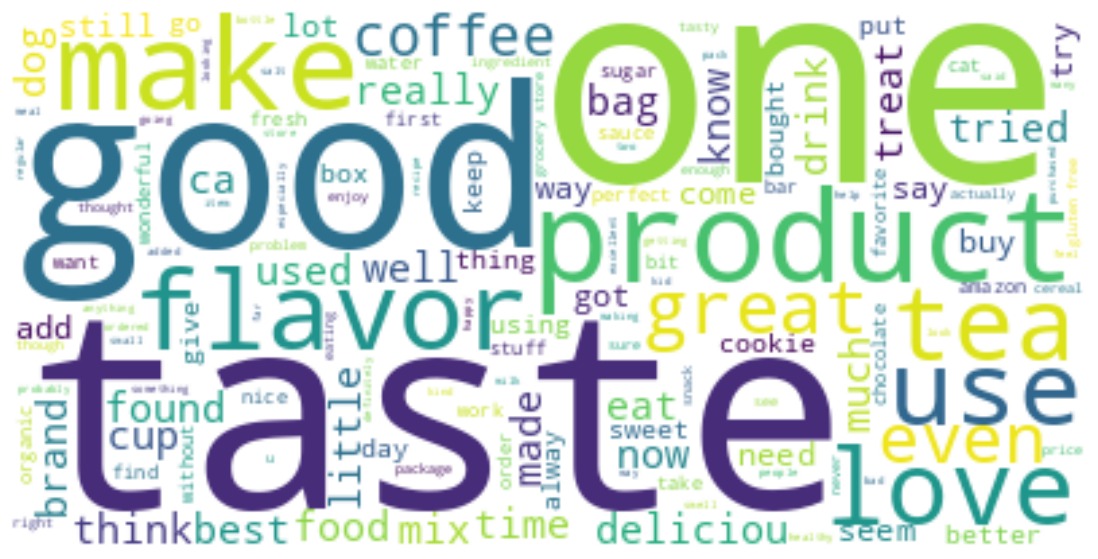

In [38]:
generate_wcloud(str(positive))

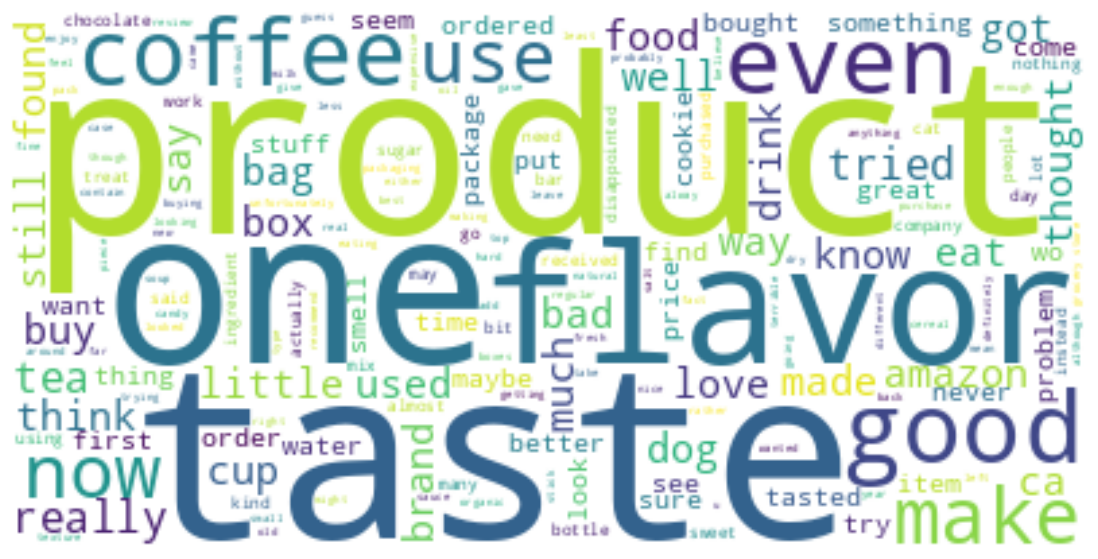

In [39]:
generate_wcloud(str(negative))

In [40]:
# count_vect = CountVectorizer(ngram_range=(1,2))
# final_bigram_counts = count_vect.fit_transform(final_df['preprocessed_text'])
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## TF-IDF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
final_tf_idf = tf_idf_vect.fit_transform(x_train)
print(final_tf_idf.shape)

(91376, 1538577)


In [42]:
#print(tf_idf_vect.get_feature_names())
print("some feature names:", list(tf_idf_vect.vocabulary_.keys())[:10])
print("length of feature list: ",len(tf_idf_vect.vocabulary_.keys()))
type(final_tf_idf)

some feature names: ['bought', 'product', 'recommendation', 'vivian', 'goldschmidt', 'osteoporosis', 'guru', 'claims', 'flouride', 'harmful']
length of feature list:  1538577


scipy.sparse._csr.csr_matrix

## Word 2 Vec

In [43]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

In [44]:
!pip install gensim

In [45]:
from gensim.models import Word2Vec

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5, vector_size = 50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))


[('awesome', 0.8529287576675415), ('fantastic', 0.8411026000976562), ('good', 0.829062283039093), ('wonderful', 0.8260103464126587), ('terrific', 0.8005651235580444), ('excellent', 0.7937023043632507), ('perfect', 0.7928155064582825), ('amazing', 0.7854728698730469), ('nice', 0.7167451977729797), ('delicious', 0.6611507534980774)]
[('nastiest', 0.8309533596038818), ('best', 0.7526511549949646), ('greatest', 0.7352240681648254), ('foulest', 0.6964714527130127), ('tastiest', 0.6591704487800598), ('disgusting', 0.6338908672332764), ('weakest', 0.6331098079681396), ('vile', 0.6211628913879395), ('horrid', 0.6010116338729858), ('terrible', 0.5982111096382141)]


In [46]:
w2v_words = list(w2v_model.wv.key_to_index.keys())
print("Number of words that occurred minimum 5 times:", len(w2v_words))
print("Sample words:", w2v_words[:50])

Number of words that occurred minimum 5 times: 18630
Sample words: ['not', 'like', 'taste', 'product', 'would', 'one', 'good', 'flavor', 'coffee', 'great', 'tea', 'no', 'get', 'food', 'love', 'really', 'amazon', 'much', 'even', 'buy', 'time', 'use', 'also', 'tried', 'price', 'make', 'little', 'better', 'try', 'could', 'now', 'well', 'find', 'first', 'chocolate', 'eat', 'box', 'bought', 'sugar', 'water', 'made', 'best', 'used', 'bag', 'dog', 'way', 'order', 'two', 'found', 'tastes']


## Logistic regression

### Logistic regression with BOW

In [47]:
#Logistic regression with GridsearchCV with BOW
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l2'],
    'C'       : [0.001, 0.01, 0.1, 1, 10],
    'solver'  : [ 'lbfgs'],
}

logreg = LogisticRegression()
lr_bow = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [48]:
lr_bow.fit(final_counts, y_train)
print("Tuned Hyperparameters :", lr_bow.best_params_)
print("Training accuracy :",lr_bow.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Training accuracy : 0.8888219458794993


In [49]:
x_test = pd.Series(np.squeeze(x_test))
print(x_test.shape, type(x_test))

(22844,) <class 'pandas.core.series.Series'>


In [50]:
x_test_bow = count_vect.transform(x_test)

In [51]:
y_pred_bow = lr_bow.predict(x_test_bow)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bow))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11453
           1       0.89      0.89      0.89     11391

    accuracy                           0.89     22844
   macro avg       0.89      0.89      0.89     22844
weighted avg       0.89      0.89      0.89     22844



In [52]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_bow)
print("Accuracy: ", accuracy)

Accuracy:  0.8889861670460515


In [53]:
y_test.value_counts()

,count
positive_negative,
0,11453
1,11391


In [54]:
pd.Series(y_pred_bow).value_counts()

,count
0,11465
1,11379


In [55]:
print(type(final_df['positive_negative']))
print(type(y_test))
print(type(y_pred_bow))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


### Logistic regression with TF-IDF

In [56]:
#Logistic regression with GridsearchCV with TF-IDF
#Using the same logreg defined earlier for BOW

# parameter grid
parameters = {
    'penalty' : ['l2'],
    'C'       : [0.001, 0.01, 0.1, 1, 10],
    'solver'  : [ 'lbfgs'],
}

lr_tf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

lr_tf.fit(final_tf_idf, y_train)
print("Tuned Hyperparameters :", lr_tf.best_params_)
print("Training accuracy :",lr_tf.best_score_)

Tuned Hyperparameters : {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Training accuracy : 0.9119571325361158


In [57]:
x_test_tf = tf_idf_vect.transform(x_test)
y_pred_tf = lr_tf.predict(x_test_tf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     11453
           1       0.91      0.91      0.91     11391

    accuracy                           0.91     22844
   macro avg       0.91      0.91      0.91     22844
weighted avg       0.91      0.91      0.91     22844



In [58]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_tf))

0.9108299772369112


### Logistic regression with W2V

In [59]:
def get_sentence_vector(sentence):
    vector_sum = np.zeros(w2v_model.vector_size)
    for word in sentence:
        if word in w2v_model.wv.key_to_index:
            vector_sum += w2v_model.wv[word]
    if len(sentence) > 0:
        return vector_sum / len(sentence)
    else:
        return vector_sum

In [60]:
x_train_WV = np.array([get_sentence_vector(sentence) for sentence in x_train])
x_test_WV = np.array([get_sentence_vector(sentence) for sentence in x_test])

In [61]:
#Logistic regression with GridsearchCV with W2V
#Using the same logreg defined earlier for BOW

# parameter grid
parameters_WV = {
    'penalty' : ['l2'],
    'C'       : [0.001, 0.01, 0.1, 1, 10],
    'solver'  : [ 'lbfgs'],
}

lr_WV = GridSearchCV(logreg,                     # model
                   param_grid = parameters_WV,   # hyperparameters
                   scoring='accuracy',           # metric for scoring
                   cv=10)                        # number of folds

In [62]:
lr_WV.fit(x_train_WV, y_train)
print("Tuned Hyperparameters :", lr_WV.best_params_)
print("Training accuracy :",lr_WV.best_score_)

Tuned Hyperparameters : {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Training accuracy : 0.6104993506951274


In [63]:
y_pred_WV = lr_WV.predict(x_test_WV)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_WV))

              precision    recall  f1-score   support

           0       0.61      0.62      0.61     11453
           1       0.61      0.59      0.60     11391

    accuracy                           0.61     22844
   macro avg       0.61      0.61      0.61     22844
weighted avg       0.61      0.61      0.61     22844



In [64]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_WV))

0.6080808965154965


## Naive Bayes

### Naive Bayes on BOW

In [65]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(final_counts, y_train)

MultinomialNB()

In [66]:
y_pred_bow_NB = model.predict(x_test_bow)

print(classification_report(y_test, y_pred_bow_NB))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     11453
           1       0.86      0.88      0.87     11391

    accuracy                           0.87     22844
   macro avg       0.87      0.87      0.87     22844
weighted avg       0.87      0.87      0.87     22844



In [67]:
accuracy = accuracy_score(y_test, y_pred_bow_NB)
print("Accuracy: ", accuracy)

Accuracy:  0.8689809140255647


### Naive Bayes on TF-IDF

In [68]:
model.fit(final_tf_idf, y_train)

y_pred_tf_NB = model.predict(x_test_tf)

print(classification_report(y_test, y_pred_bow_NB))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     11453
           1       0.86      0.88      0.87     11391

    accuracy                           0.87     22844
   macro avg       0.87      0.87      0.87     22844
weighted avg       0.87      0.87      0.87     22844



In [69]:
print(classification_report(y_test, y_pred_tf_NB))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11453
           1       0.91      0.88      0.90     11391

    accuracy                           0.90     22844
   macro avg       0.90      0.90      0.90     22844
weighted avg       0.90      0.90      0.90     22844



In [70]:
accuracy = accuracy_score(y_test, y_pred_tf_NB)
print("Accuracy: ", accuracy)

Accuracy:  0.897566100507792


### Naive Bayes on W2V

Multinomial Naive Bayes is typically used for discrete data, such as word counts or frequencies. However, Word2Vec embeddings are dense vectors that can contain negative values, which makes them unsuitable for MultinomialNB.

## Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

### RF on BOW

In [72]:
rf.fit(final_counts, y_train)

RandomForestClassifier(random_state=42)

In [73]:
y_pred_bow_rf = rf.predict(x_test_bow)
accuracy = accuracy_score(y_test, y_pred_bow_rf)
print("Accuracy:", accuracy)

Accuracy: 0.8688495885133952


### RF on TF-IDF

In [74]:
rf.fit(final_tf_idf, y_train)

RandomForestClassifier(random_state=42)

In [75]:
y_pred_tf_rf = rf.predict(x_test_tf)
accuracy = accuracy_score(y_test, y_pred_tf_rf)
print("Accuracy:", accuracy)

Accuracy: 0.8799247067063561


### RF on Word2Vec

In [76]:
rf.fit(x_train_WV, y_train)

RandomForestClassifier(random_state=42)

In [77]:
y_pred_WV_rf = rf.predict(x_test_WV)
accuracy = accuracy_score(y_test, y_pred_WV_rf)
print("Accuracy:", accuracy)

Accuracy: 0.5965242514445807
